# 제품 이상여부 판별 프로젝트


## 1. 데이터 불러오기


In [1]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


### 필수 라이브러리


In [101]:
import os
from pprint import pprint

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from xgboost import plot_importance

### 데이터 읽어오기


In [4]:
ROOT_DIR = "data"
RANDOM_STATE = 110

# Load data
train_data = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"))
train_data

,Wip Line_Dam,Process Desc._Dam,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,Insp. Seq No._Dam,Insp Judge Code_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION X Unit Time_Dam,CURE END POSITION X Judge Value_Dam,...,Production Qty Collect Result_Fill2,Production Qty Unit Time_Fill2,Production Qty Judge Value_Fill2,Receip No Collect Result_Fill2,Receip No Unit Time_Fill2,Receip No Judge Value_Fill2,WorkMode Collect Result_Fill2,WorkMode Unit Time_Fill2,WorkMode Judge Value_Fill2,target
0,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,4F1XA938-1,1,OK,240.0,NaN,NaN,...,7,NaN,NaN,127,NaN,NaN,1,NaN,NaN,Normal
1,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,3KPM0016-2,1,OK,240.0,NaN,NaN,...,185,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal
2,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4E1X9167-1,1,OK,1000.0,NaN,NaN,...,10,NaN,NaN,73,NaN,NaN,1,NaN,NaN,Normal
3,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3K1X0057-1,1,OK,1000.0,NaN,NaN,...,268,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal
4,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3HPM0007-1,1,OK,240.0,NaN,NaN,...,121,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3J1XF434-2,1,OK,240.0,NaN,NaN,...,318,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal
40502,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4E1XC796-1,1,OK,1000.0,NaN,NaN,...,14,NaN,NaN,197,NaN,NaN,1,NaN,NaN,Normal
40503,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,4C1XD438-1,1,OK,240.0,NaN,NaN,...,1,NaN,NaN,27,NaN,NaN,1,NaN,NaN,Normal
40504,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3I1XA258-1,1,OK,1000.0,NaN,NaN,...,117,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal


## 데이터 전처리

In [5]:
train_data.isna().sum()

Wip Line_Dam                         0
Process Desc._Dam                    0
Equipment_Dam                        0
Model.Suffix_Dam                     0
Workorder_Dam                        0
                                 ...  
Receip No Judge Value_Fill2      40506
WorkMode Collect Result_Fill2        0
WorkMode Unit Time_Fill2         40506
WorkMode Judge Value_Fill2       40506
target                               0
Length: 464, dtype: int64

In [6]:
cols = train_data.columns
null_list = []

for i in cols:
    if train_data[i].isna().sum() == train_data.shape[0]:
        null_list.append(i)

print(null_list)

['CURE END POSITION X Unit Time_Dam', 'CURE END POSITION X Judge Value_Dam', 'CURE END POSITION Z Unit Time_Dam', 'CURE END POSITION Z Judge Value_Dam', 'CURE END POSITION Θ Unit Time_Dam', 'CURE END POSITION Θ Judge Value_Dam', 'CURE SPEED Unit Time_Dam', 'CURE SPEED Judge Value_Dam', 'CURE STANDBY POSITION X Unit Time_Dam', 'CURE STANDBY POSITION X Judge Value_Dam', 'CURE STANDBY POSITION Z Unit Time_Dam', 'CURE STANDBY POSITION Z Judge Value_Dam', 'CURE STANDBY POSITION Θ Unit Time_Dam', 'CURE STANDBY POSITION Θ Judge Value_Dam', 'CURE START POSITION X Unit Time_Dam', 'CURE START POSITION X Judge Value_Dam', 'CURE START POSITION Z Unit Time_Dam', 'CURE START POSITION Z Judge Value_Dam', 'CURE START POSITION Θ Unit Time_Dam', 'CURE START POSITION Θ Judge Value_Dam', 'DISCHARGED SPEED OF RESIN Unit Time_Dam', 'DISCHARGED SPEED OF RESIN Judge Value_Dam', 'DISCHARGED TIME OF RESIN(Stage1) Unit Time_Dam', 'DISCHARGED TIME OF RESIN(Stage1) Judge Value_Dam', 'DISCHARGED TIME OF RESIN(Stage

In [7]:
print(len(null_list))

278


### 전체 데이터가 null인 칼럼의 개수를 확인한 결과 278개의 칼럼이 있음을 확인햇습니다.

In [8]:
train_not_null = train_data.drop(columns=null_list)

In [9]:
cols2 = train_not_null.columns
unique_cols = []

for i in cols2:
    if train_not_null[i].nunique() == 1:
        unique_cols.append(i)
        
print(unique_cols)

['Wip Line_Dam', 'Process Desc._Dam', 'Insp. Seq No._Dam', 'Insp Judge Code_Dam', 'CURE STANDBY POSITION X Collect Result_Dam', 'CURE STANDBY POSITION Z Collect Result_Dam', 'CURE STANDBY POSITION Θ Collect Result_Dam', 'CURE START POSITION Z Collect Result_Dam', 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam', 'Wip Line_AutoClave', 'Process Desc._AutoClave', 'Equipment_AutoClave', 'Insp. Seq No._AutoClave', 'Insp Judge Code_AutoClave', '1st Pressure Judge Value_AutoClave', '2nd Pressure Judge Value_AutoClave', '3rd Pressure Judge Value_AutoClave', 'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave', 'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave', 'Wip Line_Fill1', 'Process Desc._Fill1', 'Insp. Seq No._Fill1', 'Insp Judge Code_Fill1', 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1', 'Wip Line_Fill2', 'Process Desc._Fill2', 'Insp. Seq No._Fill2', 'Insp Judge Code_Fill2', 'CURE END POSITION Θ Collect Result_Fill2', 'CURE STANDBY POSITION X Collect Result_Fill2',

In [10]:
print(len(unique_cols))

40


### 278개의 칼럼을 제외하고 칼럼의 값이 하나인 칼럼의 개수만을 확인한 결과 40개의 칼럼이 하나의 값을 가지는 것을 확인했습니다 따라서 총 464개의 칼럼에서 278개 40 개의 칼럼을 제외하고 146개의 칼럼을 남겼습니다.

In [11]:
train_final = train_not_null.drop(columns = unique_cols )

In [12]:
train_final

,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,...,Head Clean Position Z Collect Result_Fill2,Head Purge Position X Collect Result_Fill2,Head Purge Position Y Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,target
0,Dam dispenser #1,AJX75334505,4F1XA938-1,240.0,2.5,-90,100,1030,-90,16,...,50.0,91.8,270,50,114.612,19.9,7,127,1,Normal
1,Dam dispenser #1,AJX75334505,3KPM0016-2,240.0,2.5,-90,70,1030,-90,10,...,91.8,270.0,50,85,19.600,7.0,185,1,0,Normal
2,Dam dispenser #2,AJX75334501,4E1X9167-1,1000.0,12.5,90,85,280,90,16,...,50.0,91.8,270,50,114.612,19.8,10,73,1,Normal
3,Dam dispenser #2,AJX75334501,3K1X0057-1,1000.0,12.5,90,70,280,90,10,...,91.8,270.0,50,85,19.900,12.0,268,1,0,Normal
4,Dam dispenser #1,AJX75334501,3HPM0007-1,240.0,2.5,-90,70,1030,-90,10,...,91.8,270.0,50,85,19.700,8.0,121,1,0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,Dam dispenser #1,AJX75334501,3J1XF434-2,240.0,2.5,-90,70,1030,-90,10,...,91.8,270.0,50,85,19.200,1.0,318,1,0,Normal
40502,Dam dispenser #2,AJX75334501,4E1XC796-1,1000.0,12.5,90,100,280,90,16,...,50.0,91.8,270,50,114.612,20.5,14,197,1,Normal
40503,Dam dispenser #1,AJX75334501,4C1XD438-1,240.0,2.5,-90,100,1030,-90,16,...,50.0,91.8,270,50,85.000,19.7,1,27,1,Normal
40504,Dam dispenser #2,AJX75334501,3I1XA258-1,1000.0,12.5,90,70,280,90,10,...,91.8,270.0,50,85,20.100,13.0,117,1,0,Normal


### 이제 train_final 데이터에서 결측치를 확인하였습니다. 결측치는 총 3개의 칼럼에서 발생했으며 각 칼럼에서 12766 개의 결측치가 발생한것으로 확인이 되며 같은 행에서 결측치가 발생한것으로 추정된다. (전체행은 40506개)

In [13]:
(train_final.isnull().sum() > 0).sum()

3

In [14]:
a= train_final.columns
null_list = a[train_final.isnull().sum() > 0]
null_list

Index(['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
       'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
       'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'],
      dtype='object')

In [15]:
cond1 = train_final['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].isna() == True
cond2 = train_final['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].isna() == True
cond3 = train_final['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].isna() == True

if ((train_final[cond1 & cond2 & cond3].shape[0]) == 12766):
    print("결측치 모두 같은 행")

결측치 모두 같은 행


In [16]:
train_final['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].unique()

array([nan, '550.3', 'OK', '162.4', '549', '549.5', '550', '548.5'],
      dtype=object)

In [17]:
train_final['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].value_counts()

HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam
OK       11293
549       7271
162.4     3580
550       2398
550.3     1909
549.5     1263
548.5       26
Name: count, dtype: int64

### 위 결과로 보아 OK 행 처럼 데이터형이 다르게 존재할 수도있음을 확이하고 이제부터 데이터형을 확인하기로 했습니다.

In [18]:
cols = train_final.columns
OK_list = []

for i in cols:
    a = train_data[train_data[i] == 'OK'].shape[0]
    OK_list.append(a)

In [19]:
np.nonzero(OK_list)

(array([ 16,  79,  90, 122]),)

In [20]:
train_final.iloc[:,[ 16,  79,  90, 122]]

,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam,Chamber Temp. Judge Value_AutoClave,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2
0,NaN,OK,NaN,NaN
1,550.3,OK,838.4,835.5
2,OK,OK,OK,OK
3,162.4,OK,837.7,305
4,549,NG,838.4,835.5
...,...,...,...,...
40501,550.3,OK,838.4,835.5
40502,NaN,NG,NaN,NaN
40503,OK,NG,OK,OK
40504,162.4,OK,837.7,305


In [21]:
train_final['Chamber Temp. Judge Value_AutoClave'].value_counts()

Chamber Temp. Judge Value_AutoClave
OK    29112
NG    11394
Name: count, dtype: int64

### 총 4개의 칼럼에서 OK 가 존재하고 null이 존재하는 세개의 칼럼(HEAD NORMAL COORDINATE X AXIS(Stage1)~~)이외에 Chamber Temp. Judge Value_AutoClave 칼럼에서 OK NG 이진인코딩 가능

In [22]:
type_list = train_final.dtypes

In [23]:
a = train_final.dtypes
display('데이터 타입의 종류 %s' %a.unique())

display('칼럼중 object 타입의 개수 %d' %len(a[a == object]))

display('object 타입의 칼럼들')
display(a[a == object])

"데이터 타입의 종류 [dtype('O') dtype('float64') dtype('int64')]"

'칼럼중 object 타입의 개수 16'

'object 타입의 칼럼들'

Equipment_Dam                                                 object
Model.Suffix_Dam                                              object
Workorder_Dam                                                 object
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam      object
Model.Suffix_AutoClave                                        object
Workorder_AutoClave                                           object
Chamber Temp. Judge Value_AutoClave                           object
Equipment_Fill1                                               object
Model.Suffix_Fill1                                            object
Workorder_Fill1                                               object
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1    object
Equipment_Fill2                                               object
Model.Suffix_Fill2                                            object
Workorder_Fill2                                               object
HEAD NORMAL COORDINATE X AXIS(Stag

### object 타입의 칼럼을 확인하자

In [24]:
a_ind = a[a == object].index
tmp = train_final.loc[:,a_ind]

object_list = tmp.nunique()
index_list2 = object_list[object_list== 2].index
index_list3 = object_list[object_list== 3].index
index_list6 = object_list[object_list== 6].index
index_list7 = object_list[object_list== 7].index
index_list663 = object_list[object_list== 663].index

In [25]:
train_final.loc[:,index_list663]

,Workorder_Dam,Workorder_AutoClave,Workorder_Fill1,Workorder_Fill2
0,4F1XA938-1,4F1XA938-1,4F1XA938-1,4F1XA938-1
1,3KPM0016-2,3KPM0016-2,3KPM0016-2,3KPM0016-2
2,4E1X9167-1,4E1X9167-1,4E1X9167-1,4E1X9167-1
3,3K1X0057-1,3K1X0057-1,3K1X0057-1,3K1X0057-1
4,3HPM0007-1,3HPM0007-1,3HPM0007-1,3HPM0007-1
...,...,...,...,...
40501,3J1XF434-2,3J1XF434-2,3J1XF434-2,3J1XF434-2
40502,4E1XC796-1,4E1XC796-1,4E1XC796-1,4E1XC796-1
40503,4C1XD438-1,4C1XD438-1,4C1XD438-1,4C1XD438-1
40504,3I1XA258-1,3I1XA258-1,3I1XA258-1,3I1XA258-1


In [26]:
print(train_final[(train_final['Workorder_Dam']) == (train_final['Workorder_AutoClave'])].shape[0])
print(train_final[(train_final['Workorder_Fill1']) == (train_final['Workorder_Fill2'])].shape[0])
print(train_final[(train_final['Workorder_Dam']) == (train_final['Workorder_Fill1'])].shape[0])

40506
40506
40506


### index_list663는 모두 같은 값을 가지므로 하나의 칼럼만 사용한다. 다른 칼럼 또한 이런 경우가 있는지 확인하고 제거하기 위해 
### df = df.T.drop_duplicates().T 을 통해 삭제를 진행 그리고 데이터 형 변환으로 인해 숫자형이 가능한 칼럼은 숫자형으로 변환

In [27]:
train_final = train_final.T.drop_duplicates().T

for col in train_final.columns:
    train_final[col] = pd.to_numeric(train_final[col], errors='ignore')

In [28]:
train_final.shape

(40506, 124)

### train_final 146 개의 칼럼 에서 추가로 22 개의 칼럼을 더 제거하여 총 124개의 칼럼으로 축소

### 칼럼값이 두개로 이루어진 칼럼이 30개 존재 이 데이터는 바이너리 인코딩을 통해 처리하는 것이 용이할 것으로 생각된다.

In [29]:
a = train_final.nunique()
sum(a>= 100)
#100이 넘는 데이터 11개 확인

11

In [30]:
cols3 = train_final.columns
unique_cols2 = []
for i in cols3:
    if train_final[i].nunique() == 2:
        unique_cols2.append(i)
        
print(unique_cols2 , len(unique_cols2))

['Equipment_Dam', 'CURE END POSITION X Collect Result_Dam', 'CURE END POSITION Z Collect Result_Dam', 'CURE END POSITION Θ Collect Result_Dam', 'CURE START POSITION X Collect Result_Dam', 'HEAD Standby Position Y Collect Result_Dam', 'HEAD Standby Position Z Collect Result_Dam', 'Head Clean Position X Collect Result_Dam', 'Head Clean Position Y Collect Result_Dam', 'Head Zero Position X Collect Result_Dam', 'Chamber Temp. Judge Value_AutoClave', 'Equipment_Fill1', 'HEAD Standby Position Y Collect Result_Fill1', 'HEAD Standby Position Z Collect Result_Fill1', 'Head Clean Position X Collect Result_Fill1', 'Head Clean Position Y Collect Result_Fill1', 'Head Clean Position Z Collect Result_Fill1', 'Head Purge Position X Collect Result_Fill1', 'Equipment_Fill2', 'CURE END POSITION X Collect Result_Fill2', 'CURE START POSITION X Collect Result_Fill2', 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2', 'HEAD Standby Position Y Collect Result_Fill2', 'HEAD Standby Position Z Collect

### 이후 상관 계수를 사용하여 다중공선성을 줄이기 위해 칼럼을 축소

In [31]:
train_final.head(3)

,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,...,Head Clean Position Y Collect Result_Fill2,Head Clean Position Z Collect Result_Fill2,Head Purge Position X Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,target
0,Dam dispenser #1,AJX75334505,4F1XA938-1,240.0,2.5,-90,100,1030,16,14.9,...,119,50.0,91.8,50,114.612,19.9,7,127,1,Normal
1,Dam dispenser #1,AJX75334505,3KPM0016-2,240.0,2.5,-90,70,1030,10,21.3,...,50,91.8,270.0,85,19.600,7.0,185,1,0,Normal
2,Dam dispenser #2,AJX75334501,4E1X9167-1,1000.0,12.5,90,85,280,16,14.7,...,119,50.0,91.8,50,114.612,19.8,10,73,1,Normal


In [32]:
null_list = []
cols = train_final.columns

for i in cols:
    if train_final[i].isna().sum() > 0 :
        null_list.append(i)

print(null_list)

['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2']


In [33]:
null_list = a[train_final.isnull().sum() > 0]
null_list

HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam      7
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1    6
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2    3
dtype: int64

In [34]:
null_list.index[0]

'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'

In [35]:
train_final[null_list.index[0]].value_counts()

HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam
OK       11293
549       7271
162.4     3580
550       2398
550.3     1909
549.5     1263
548.5       26
Name: count, dtype: int64

In [36]:
train_final[null_list.index[1]].value_counts()

HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1
OK       11293
838.4     7658
837.9     4957
837.7     3577
838.2      253
837.5        2
Name: count, dtype: int64

In [37]:
train_final[null_list.index[2]].value_counts()

HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2
835.5    12868
OK       11293
305       3579
Name: count, dtype: int64

In [38]:
df_corr = train_final.select_dtypes(exclude='object')

In [39]:
df_corr

,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,...,Head Clean Position X Collect Result_Fill2,Head Clean Position Y Collect Result_Fill2,Head Clean Position Z Collect Result_Fill2,Head Purge Position X Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2
0,240.0,2.5,-90,100,1030,16,14.9,8.4,14.7,1.04,...,-10,119,50.0,91.8,50,114.612,19.9,7,127,1
1,240.0,2.5,-90,70,1030,10,21.3,4.9,21.3,1.49,...,119,50,91.8,270.0,85,19.600,7.0,185,1,0
2,1000.0,12.5,90,85,280,16,14.7,8.5,14.7,1.61,...,-10,119,50.0,91.8,50,114.612,19.8,10,73,1
3,1000.0,12.5,90,70,280,10,21.3,8.4,21.3,1.49,...,119,50,91.8,270.0,85,19.900,12.0,268,1,0
4,240.0,2.5,-90,70,1030,10,9.7,4.9,9.6,0.67,...,119,50,91.8,270.0,85,19.700,8.0,121,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,240.0,2.5,-90,70,1030,10,17.0,5.0,17.0,1.19,...,119,50,91.8,270.0,85,19.200,1.0,318,1,0
40502,1000.0,12.5,90,100,280,16,14.9,8.5,14.7,1.04,...,-10,119,50.0,91.8,50,114.612,20.5,14,197,1
40503,240.0,2.5,-90,100,1030,16,14.2,8.2,14.3,0.99,...,-10,119,50.0,91.8,50,85.000,19.7,1,27,1
40504,1000.0,12.5,90,70,280,10,9.7,4.9,9.7,0.67,...,119,50,91.8,270.0,85,20.100,13.0,117,1,0


In [40]:
corr_matrix = df_corr.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

threshold = 0.8
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

df_cleaned = df_corr.drop(columns=to_drop)

In [41]:
# 상괸계수를 고려하여 제거한 데이터 프레임의 칼럼의 개수를 확인 32개 하지만 이 경우 칼럼이 object인 경우는 제외하고 구한것이다
df_cleaned.shape[1]

32

In [42]:
train_final.select_dtypes('object').nunique()

Equipment_Dam                                                   2
Model.Suffix_Dam                                                7
Workorder_Dam                                                 663
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam        7
Chamber Temp. Judge Value_AutoClave                             2
Equipment_Fill1                                                 2
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1      6
Equipment_Fill2                                                 2
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2      3
target                                                          2
dtype: int64

In [43]:
df_object =train_final.select_dtypes('object')
display(df_object.head(3))
display(df_object.shape)

,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam,Chamber Temp. Judge Value_AutoClave,Equipment_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1,Equipment_Fill2,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2,target
0,Dam dispenser #1,AJX75334505,4F1XA938-1,NaN,OK,Fill1 dispenser #1,NaN,Fill2 dispenser #1,NaN,Normal
1,Dam dispenser #1,AJX75334505,3KPM0016-2,550.3,OK,Fill1 dispenser #1,838.4,Fill2 dispenser #1,835.5,Normal
2,Dam dispenser #2,AJX75334501,4E1X9167-1,OK,OK,Fill1 dispenser #2,OK,Fill2 dispenser #2,OK,Normal


(40506, 10)

In [44]:
display(df_cleaned.head(3))
display(df_cleaned.shape)

,CURE END POSITION X Collect Result_Dam,CURE SPEED Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam,HEAD Standby Position X Collect Result_Dam,...,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1,Dispense Volume(Stage3) Collect Result_Fill1,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1,CURE END POSITION X Collect Result_Fill2,CURE END POSITION Z Collect Result_Fill2,CURE SPEED Collect Result_Fill2,CURE STANDBY POSITION Z Collect Result_Fill2,WorkMode Collect Result_Fill2
0,240.0,100,16,14.9,8.4,1.04,464.3,161.4,274.51,274.51,...,3.6,12.6,11.97,244.520,244.520,240,33,48,33,1
1,240.0,70,10,21.3,4.9,1.49,160.8,377.3,282.15,257.00,...,3.6,13.5,12.82,244.400,244.400,240,33,50,33,0
2,1000.0,85,16,14.7,8.5,1.61,465.4,551.7,274.33,274.33,...,3.5,13.4,12.73,244.415,244.415,240,33,50,33,1


(40506, 32)

In [45]:
df = pd.concat([df_cleaned,df_object],axis=1)

In [46]:
df = df.drop(columns=null_list.index)

In [47]:
df.shape[1]

39

### 언더 샘플링


In [48]:
df.target.value_counts()

target
Normal      38156
AbNormal     2350
Name: count, dtype: int64

데이타 불균형을 해결하기 위해 언더 샘플링을 진행합니다.


In [49]:
train_data = df
train_data.head()

,CURE END POSITION X Collect Result_Dam,CURE SPEED Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam,HEAD Standby Position X Collect Result_Dam,...,CURE SPEED Collect Result_Fill2,CURE STANDBY POSITION Z Collect Result_Fill2,WorkMode Collect Result_Fill2,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,Chamber Temp. Judge Value_AutoClave,Equipment_Fill1,Equipment_Fill2,target
0,240.0,100,16,14.9,8.4,1.04,464.3,161.4,274.51,274.51,...,48,33,1,Dam dispenser #1,AJX75334505,4F1XA938-1,OK,Fill1 dispenser #1,Fill2 dispenser #1,Normal
1,240.0,70,10,21.3,4.9,1.49,160.8,377.3,282.15,257.00,...,50,33,0,Dam dispenser #1,AJX75334505,3KPM0016-2,OK,Fill1 dispenser #1,Fill2 dispenser #1,Normal
2,1000.0,85,16,14.7,8.5,1.61,465.4,551.7,274.33,274.33,...,50,33,1,Dam dispenser #2,AJX75334501,4E1X9167-1,OK,Fill1 dispenser #2,Fill2 dispenser #2,Normal
3,1000.0,70,10,21.3,8.4,1.49,552.0,1271.8,282.15,257.00,...,50,33,0,Dam dispenser #2,AJX75334501,3K1X0057-1,OK,Fill1 dispenser #2,Fill2 dispenser #2,Normal
4,240.0,70,10,9.7,4.9,0.67,159.5,377.5,284.80,257.00,...,50,33,0,Dam dispenser #1,AJX75334501,3HPM0007-1,NG,Fill1 dispenser #1,Fill2 dispenser #1,Normal


In [50]:
normal_ratio = 1.0  # 1.0 means 1:1 ratio

df_normal = train_data[train_data["target"] == "Normal"]
df_abnormal = train_data[train_data["target"] == "AbNormal"]

num_normal = len(df_normal)
num_abnormal = len(df_abnormal)
print(f"  Total: Normal: {num_normal}, AbNormal: {num_abnormal}")

df_normal = df_normal.sample(n=int(num_abnormal * normal_ratio), replace=False, random_state=RANDOM_STATE)
df_concat = pd.concat([df_normal, df_abnormal], axis=0).reset_index(drop=True)
df_concat.value_counts("target")

  Total: Normal: 38156, AbNormal: 2350


target
AbNormal    2350
Normal      2350
Name: count, dtype: int64

col6 = "Chamber Temp. Judge Value_AutoClave"

def process_head_normal6(data):
    if data == "OK":
        return "1"
    elif data == "NG":
        return "0"


train_data[col6] = train_data[col6].apply(process_head_normal6)
test_data[col6] = test_data[col6].apply(process_head_normal6)

### 데이터 분할


df_train, df_val = train_test_split(
    df_concat,
#     test_size=0.3,
    test_size=0.3,
    stratify=df_concat["target"],
    random_state=RANDOM_STATE,
)


def print_stats(df: pd.DataFrame):
    num_normal = len(df[df["target"] == "Normal"])
    num_abnormal = len(df[df["target"] == "AbNormal"])

    print(f"  Total: Normal: {num_normal}, AbNormal: {num_abnormal}" + f" ratio: {num_abnormal/num_normal}")


# Print statistics
print(f"  \tAbnormal\tNormal")
print_stats(df_train)
print_stats(df_val)

## 3. 모델 학습


### 모델 정의


In [135]:
model = XGBClassifier(random_state=RANDOM_STATE, enable_categorical=True)

In [136]:
test_data = pd.read_csv(os.path.join(ROOT_DIR, "test.csv"))
test_data= test_data.loc[:,train_data.columns]

df_object =df_train.select_dtypes('object')
df_object

,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,Chamber Temp. Judge Value_AutoClave,Equipment_Fill1,Equipment_Fill2,target
4417,Dam dispenser #1,AJX75334501,3G1XA483-1,NG,Fill1 dispenser #1,Fill2 dispenser #1,AbNormal
1383,Dam dispenser #1,AJX75334501,3H1X7981-1,OK,Fill1 dispenser #1,Fill2 dispenser #1,Normal
895,Dam dispenser #1,AJX75334501,3G1XA482-1,OK,Fill1 dispenser #1,Fill2 dispenser #1,Normal
1270,Dam dispenser #2,AJX75334501,3M1XC580-1,NG,Fill1 dispenser #2,Fill2 dispenser #2,Normal
1002,Dam dispenser #2,AJX75334501,3L1X1373-1,OK,Fill1 dispenser #2,Fill2 dispenser #2,Normal
...,...,...,...,...,...,...,...
3021,Dam dispenser #1,AJX75334501,3I1XA253-1,OK,Fill1 dispenser #1,Fill2 dispenser #1,AbNormal
2973,Dam dispenser #1,AJX75334501,3G1XD171-2,OK,Fill1 dispenser #1,Fill2 dispenser #1,AbNormal
4040,Dam dispenser #2,AJX75334501,4A1XE165-1,NG,Fill1 dispenser #2,Fill2 dispenser #2,AbNormal
2294,Dam dispenser #2,AJX75334501,3L1X1373-1,OK,Fill1 dispenser #2,Fill2 dispenser #2,Normal


In [137]:
object_list = df_object.select_dtypes('object').columns.to_list()
object_list.remove('target')
object_list.remove('Workorder_Dam')

In [138]:
# # 라벨 인코딩 object 칼럼에 대하여
# from sklearn.preprocessing import LabelEncoder

# def label_encode_with_unknowns(encoder, data):
#     return [encoder.transform([x])[0] if x in encoder.classes_ else -1 for x in data]

# le = LabelEncoder()

# for object in object_list:
#     le.fit(df_train[object])
#     df_train[object] = le.transform(df_train[object])
#     test_data[object] = label_encode_with_unknowns(le, test_data[object])

### 모델 학습


In [139]:
# features = []

# for col in df_train.columns:
#     try:
#         df_train[col] = df_train[col].astype(int)
#         features.append(col)
#     except:
#         continue

# train_x = df_train[features]
# train_y = df_train["target"]


In [140]:
train_data = train_data.astype({col: 'category' for col in train_data.select_dtypes(include=['object']).columns})
test_data = test_data.astype({col: 'category' for col in test_data.select_dtypes(include=['object']).columns})    

In [141]:
df_train, df_val = train_test_split(
    df_concat,
#     test_size=0.3,
    test_size=0.3,
    stratify=df_concat["target"],
    random_state=RANDOM_STATE,
)


def print_stats(df: pd.DataFrame):
    num_normal = len(df[df["target"] == "Normal"])
    num_abnormal = len(df[df["target"] == "AbNormal"])

    print(f"  Total: Normal: {num_normal}, AbNormal: {num_abnormal}" + f" ratio: {num_abnormal/num_normal}")

# Print statistics
print(f"  \tAbnormal\tNormal")
print_stats(df_train)
print_stats(df_val)

  	Abnormal	Normal
  Total: Normal: 1645, AbNormal: 1645 ratio: 1.0
  Total: Normal: 705, AbNormal: 705 ratio: 1.0


In [142]:
train_x = df_train.drop('target', axis =1)
train_y = df_train["target"]
train_x.drop('Workorder_Dam', axis =1,inplace=True)
X_val = df_val.drop('target', axis =1)
Y_val = df_val["target"]
X_val.drop('Workorder_Dam', axis =1,inplace=True)

test_data = pd.read_csv(os.path.join(ROOT_DIR, "test.csv"))
test_data= test_data.loc[:,train_x.columns]

In [143]:
# 라벨 인코딩 object 칼럼에 대하여

from sklearn.preprocessing import OneHotEncoder

numeric_cols = train_x.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = train_x.select_dtypes(include=['object', 'category']).columns

encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoder.fit(train_x[categorical_cols])

train_encoded = encoder.transform(train_x[categorical_cols])
test_encoded = encoder.transform(test_data[categorical_cols])

train_encoded_df = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out(categorical_cols))
test_encoded_df = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out(categorical_cols))

result_df_train = pd.concat([train_x[numeric_cols].reset_index(drop=True), train_encoded_df.reset_index(drop=True)], axis=1)
result_df_test = pd.concat([test_data[numeric_cols].reset_index(drop=True), test_encoded_df.reset_index(drop=True)], axis=1)

train_x=result_df_train
test_data=result_df_test

/home/elicer/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [144]:
train_y = LabelEncoder().fit_transform(train_y)

In [145]:
xgb_model = model.fit(train_x, train_y)

## 4. 제출하기


In [146]:
train_x.shape[1]

47

### 테스트 데이터 예측


테스트 데이터 불러오기


In [147]:
# df_test_x = test_data[features]

# for col in df_test_x.columns:
#     try:
#         df_test_x.loc[:, col] = df_test_x[col].astype(int)
#     except:
#         continue

In [148]:
df_test_x = test_data

In [149]:
test_pred = xgb_model.predict(X_val)
test_pred

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:Equipment_Dam: object, Model.Suffix_Dam: object, Chamber Temp. Judge Value_AutoClave: object, Equipment_Fill1: object, Equipment_Fill2: object

In [97]:
y_pred_probs = xgb_model.predict_proba(df_test_x)[:,1]
y_pred_probs

array([0.45591563, 0.88152903, 0.45652652, ..., 0.7948666 , 0.6079452 ,
       0.5002019 ], dtype=float32)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

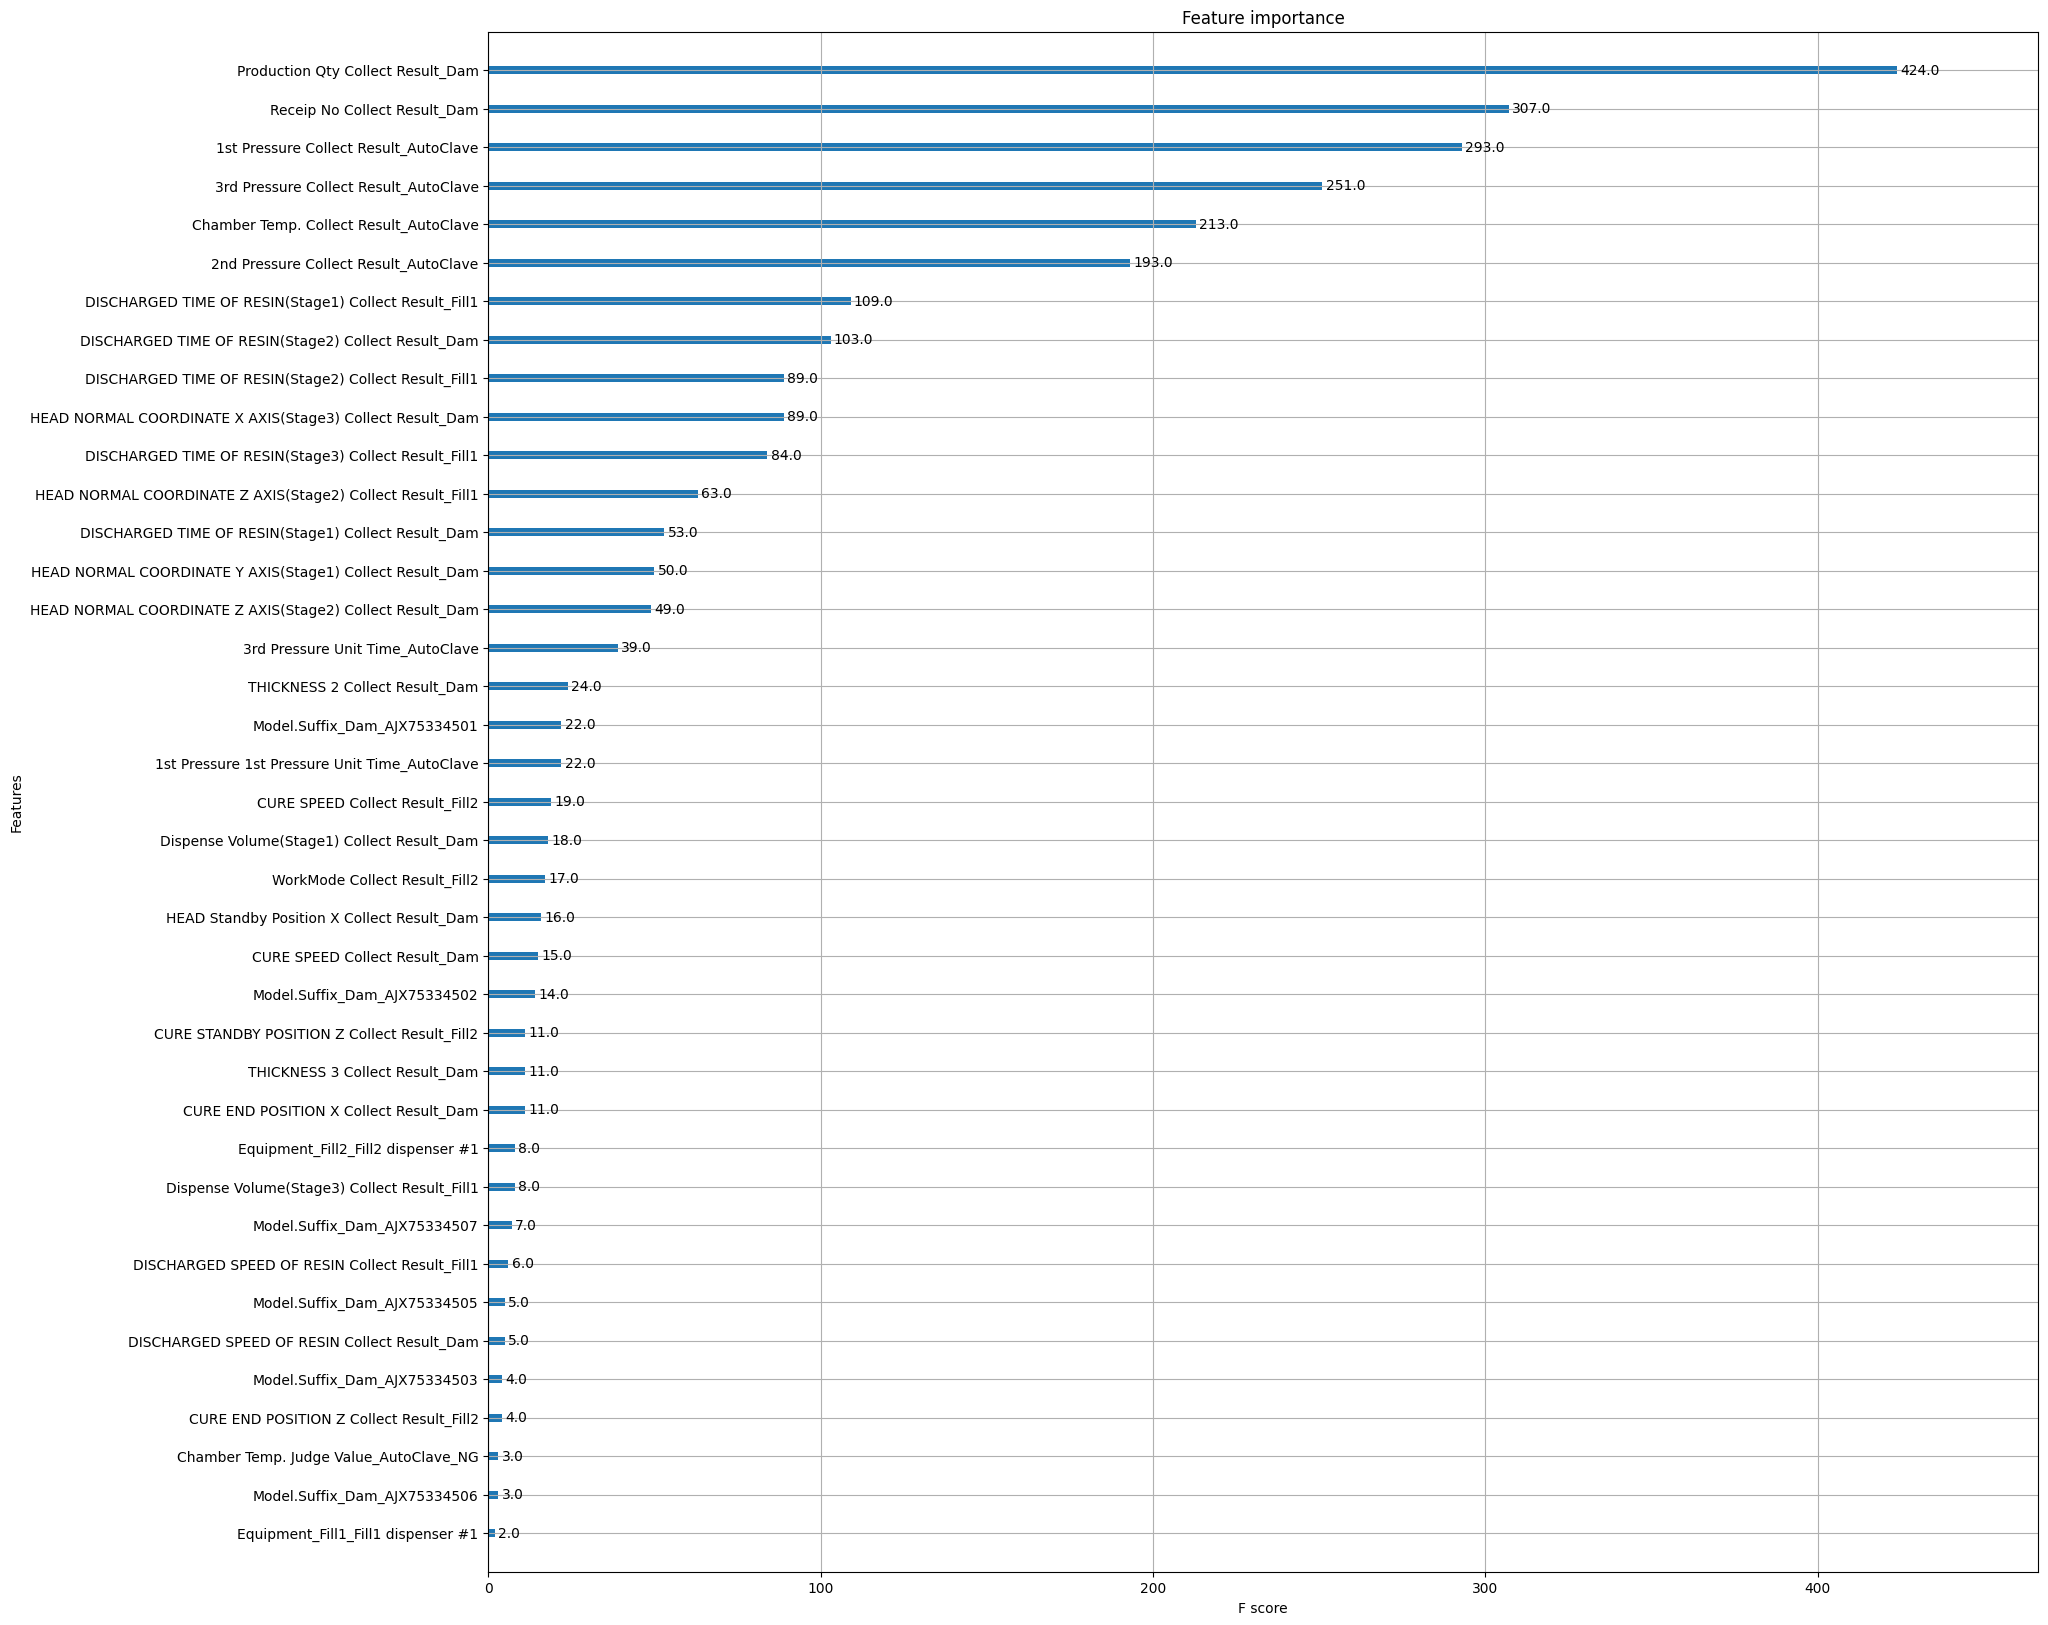

In [103]:
fig, ax = plt.subplots(figsize=(20,20))
plot_importance(xgb_model, ax=ax)

### Val을 통한 F1

In [107]:
f1 = f1_score(Y_val, test_pred)
f1

NameError: name 'yYval' is not defined

### 제출 파일 작성


In [320]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = test_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

**우측 상단의 제출 버튼을 클릭해 결과를 확인하세요**


약 40개의 칼럼을 가지고 학습을 진행한 경우 42개의 칼럼 but features = [] astype(int) 로 인해 32개만이 존재
object 유형의 칼럼중 Workorder_Dam 663인 칼럼을 제외하고 라벨 인코딩 or one -out encoding 이 필요

test : val 0.7 : 0.3

F1 = 0.13997181775481446 언더 샘플링 진행   (1645개의 train)

F1 = 0.12382234185733512언더 샘플링 진행 X (1645개의 train)

test : val 0.9 : 0.1

F1 = 0.13470533208606175      (2115개의 train)

37개의 칼럼 //  42개에서 결측치 칼럼 3개 제외 39개에서 target, Workorder_Dam을 제외함 + 라벨 인코딩(object)

F1 = 0.13661332696441367 (1645개의 train)

37개의 칼럼 // 42개에서 결측치 칼럼 3개 제외 39개에서 target, Workorder_Dam을 제외함 + one-hot 인코딩(object)

F1 = 0.13269493844049246 (1645개의 train)

약간의 결론을 내리자면 결측치 칼럼 3개 제외한 object 칼럼은 모델 성능을 오히려 떨어뜨리는 경향을 보인다 결측치 칼럼 3개는 어떻게 처리할지 잘 모르겠지만 나머지 object 칼럼은 제외하는 쪽이 오히려 좋아 보인다